# Tool for text analysis

### Description:

The aim of this tool is to provide them means to evalutate the presence of bias between documents in two distinct languages. The main characteristics, topics and sentiment analysis are also evaluated. Here we are using the wikipedia article on "democracy" in several languages as example, to analyze how differently the concept is described.

## Topics:



*   Main characteristics
*   Topic extraction
*   Text similarity
*   Sentiment analysis





## Setup:

This chapter contains the main imports and setu´for the project

In [ ]:
!pip install sentence_transformers
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
import torch
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Main characteristics:

This section contains algorithms for a basic preprocessing of textual data, as well as word and sentence tokenizing. As of now, we are still facing some challenges related to the formation of words and sentences in different languages (example, a chinese sentence and word is formed in a completely different way than a word or sentence in German or English).

### Samples:



*   CNN artticle on the violence in Ecuador: https://edition.cnn.com/2024/01/25/americas/ecuador-gangs-terror-cartels-intl/index.html
*   Wikipedia article on democracy: https://en.wikipedia.org/wiki/Democracy



### Procedures for simple articles:

The section contains the extraction of main characteristics of words and sentences from a document.

#### Reading article from wikipedia:

The following code gets the basic metrics (number of words and sentences) from a document in standard latin alphabet.

In [ ]:
def get_basic_metrics(urls, labels):
  words = []
  nsentences = []
  for url in urls:
    sample_page = url
    page = requests.get(sample_page)
    soup = BeautifulSoup(page.text)
    text_ps = [re.sub(r'\[[0-9]*\]', '', x.getText()) for x in soup.find_all('p')]
    text_ps = ' '.join(text_ps)
    words.append(len(text_ps.split()))
    sentences = sent_tokenize(text_ps)
    nsentences.append(len(sentences))
  print(words)
  print(nsentences)
  df = pd.DataFrame(index = labels, data = {
      'Number of words': words,
      'Number of sentences': nsentences
  })
  return df

In this section we aim to scrappe and extract number of sentences and words from a Wikipedia article.

The following method extracts sentences from texts in standard punctuation system:

In [ ]:
def get_sentences(sample_page, language):
  print(sample_page)
  page = requests.get(sample_page)
  soup = BeautifulSoup(page.text)
  text_ps = [re.sub(r'\[[0-9]*\]', '', x.getText()) for x in soup.find_all('p')]
  text_ps = [x.lower() for x in text_ps]
  text_ps_en = [re.sub(r'[,\.!?\"]', '', x) for x in text_ps]
  stop_words = stopwords.words(language.lower())
  complete = []
  for sent in text_ps_en:
    text = []
    for word in [x for x in sent.split()]:
      if word not in stop_words:
        text.append(word)
    text = ' '.join(text)
    complete.append(text)
  return complete

In [ ]:
sample_pages = ["https://en.wikipedia.org/wiki/Democracy",
                "https://es.wikipedia.org/wiki/Democracia",
                "https://pt.wikipedia.org/wiki/Democracia",
                "https://it.wikipedia.org/wiki/Democrazia",
                "https://de.wikipedia.org/wiki/Demokratie",
                "https://fr.wikipedia.org/wiki/D%C3%A9mocratie",
                "https://el.wikipedia.org/wiki/%CE%94%CE%B7%CE%BC%CE%BF%CE%BA%CF%81%CE%B1%CF%84%CE%AF%CE%B1",
                "https://tr.wikipedia.org/wiki/Demokrasi",
                "https://nl.wikipedia.org/wiki/Democratie",
                "https://hu.wikipedia.org/wiki/Demokr%C3%A1cia_(politikai_rendszer)",
                "https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F"
]

languages = ["english",
             "spanish",
             "portuguese",
             "italian",
             "german",
             "french",
             "greek",
             "turkish",
             "dutch",
             "hungarian",
             "russian"
             ]

Retrieving basic metrics for all languages above:

In [ ]:
basic_metrics = get_basic_metrics(sample_pages, languages).reset_index().sort_values(by="Number of words", ascending=False)

[11567, 8640, 4078, 4512, 16188, 13309, 543, 8966, 2538, 3932, 4550]
[495, 214, 144, 144, 691, 471, 27, 519, 138, 230, 218]


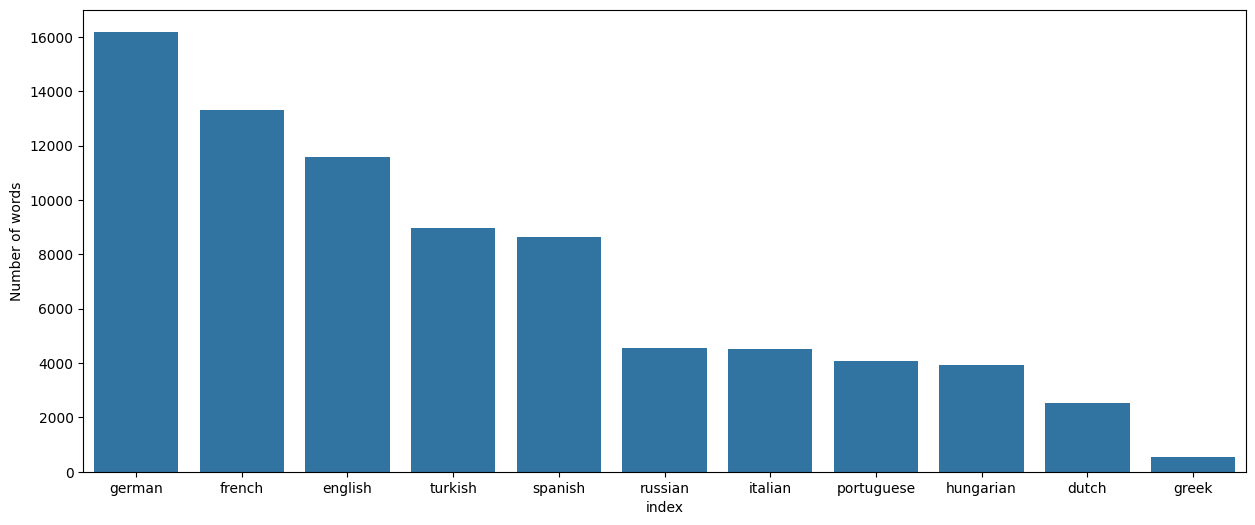

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(basic_metrics, x="index", y="Number of words")
plt.show()

In [ ]:
by_sentences = basic_metrics.sort_values(by="Number of sentences", ascending=False)

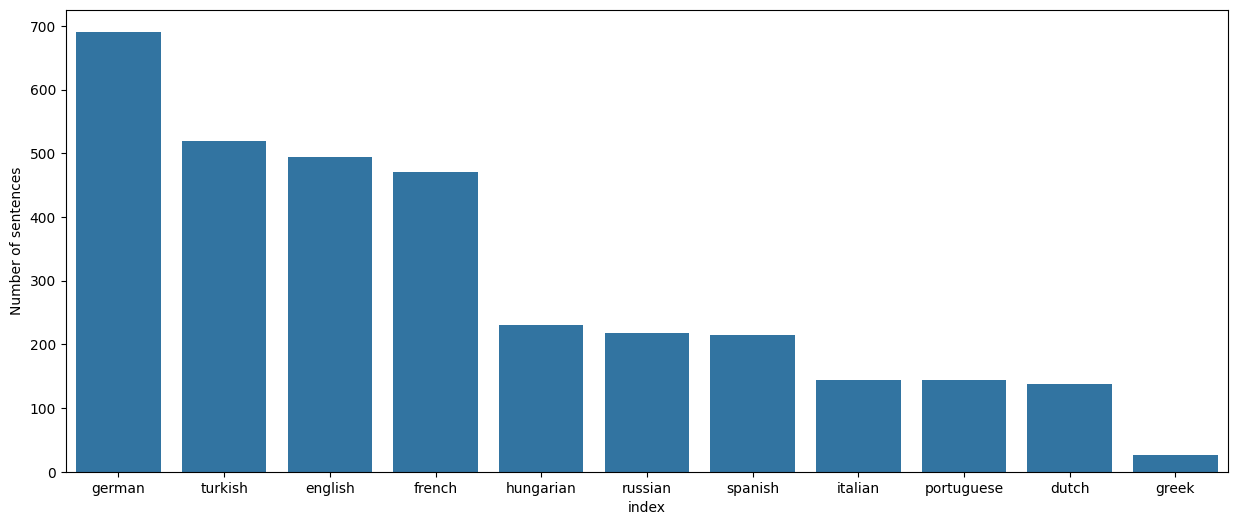

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(by_sentences, x="index", y="Number of sentences")
plt.show()

We notice some clear trends:

*   There seems to be no correlation with how democratic [1] countries are in 2024 and their respective languages. For instance, Turkey is ranked by V-Dem [1] as an electoral autocracy, but the article in Turkish is one of the biggest on Wikipedia. The articles in Hungarian and Russian are bigger than the ones in Italian or Portuguese.
*   It is interesting that the article in German is the biggest one, provided that multiple German words are often put together in a single word.
*   The number of sentences for all these languages seems to correlate with the number of words, indicating proportional sizing of sentences.





#### Reading links:

The following code extracts all of the hyperlinks from the document:

In [ ]:
links_total = [link.get('href') for link in soup.find_all('a')];
not_null = [i for i in links_total if i is not None]
[link for link in not_null if link.startswith("http")]

['https://donate.wikimedia.org/wiki/Special:FundraiserRedirector?utm_source=donate&utm_medium=sidebar&utm_campaign=C13_en.wikipedia.org&uselang=en',
 'https://af.wikipedia.org/wiki/Demokrasie',
 'https://als.wikipedia.org/wiki/Demokratie',
 'https://am.wikipedia.org/wiki/%E1%8B%B4%E1%88%9E%E1%8A%AD%E1%88%AB%E1%88%B2',
 'https://anp.wikipedia.org/wiki/%E0%A4%AA%E0%A5%8D%E0%A4%B0%E0%A4%9C%E0%A4%BE%E0%A4%A4%E0%A4%82%E0%A4%A4%E0%A5%8D%E0%A4%B0',
 'https://ar.wikipedia.org/wiki/%D8%AF%D9%8A%D9%85%D9%82%D8%B1%D8%A7%D8%B7%D9%8A%D8%A9',
 'https://an.wikipedia.org/wiki/Democracia',
 'https://as.wikipedia.org/wiki/%E0%A6%97%E0%A6%A3%E0%A6%A4%E0%A6%A8%E0%A7%8D%E0%A6%A4%E0%A7%8D%E0%A7%B0',
 'https://ast.wikipedia.org/wiki/Democracia',
 'https://gn.wikipedia.org/wiki/Jekopytyjoja',
 'https://av.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F',
 'https://az.wikipedia.org/wiki/Demokratiya',
 'https://azb.wikipedia.org/wiki/%D8%AF%D9%85%D9%88%DA%A9%D8%B1%D8%A7%D8%B3%DB%

## Topic modelling:

Using as bases:



*   https://bennett-holiday.medium.com/a-step-by-step-guide-to-writing-an-lda-program-in-python-690aa99119ea
*   https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf



Now we wish to find the latent topics present in the documents

In [ ]:
sample_page = "https://en.wikipedia.org/wiki/democracy"
text_ps = get_sentences(sample_page, "English")
print(text_ps)

['', 'list forms government', "democracy (from ancient greek: δημοκρατία romanized: dēmokratía dēmos 'people' kratos 'rule') system government state power vested people general population state minimalist definition democracy rulers elected competitive elections expansive definitions link democracy guarantees civil liberties human rights addition competitive elections", 'direct democracy people direct authority deliberate decide legislation representative democracy people choose governing officials elections considered part people authority shared among delegated people changed time different rates different countries features democracy oftentimes include freedom assembly association personal property freedom religion speech citizenship consent governed voting rights freedom unwarranted governmental deprivation right life liberty minority rights', 'notion democracy evolved time considerably throughout history one find evidence direct democracy communities make decisions popular assembl

Now we will collect the text in German:

In [ ]:
sample_page = "https://de.wikipedia.org/wiki/Demokratie"
text_de = get_sentences(sample_page, "German")
print(text_de)

['demokratie (von altgriechisch δημοκρατία dēmokratía volksherrschaft) begriff formen herrschaftsorganisation grundlage partizipation bzw teilhabe politischen willensbildung handelt zentralen begriff politikwissenschaft ursprünglich staatsformenlehre stammt demokratietheorie erörtert erste begriffliche erwähnung findet bezogen attische demokratie herodot ideengeschichtlich wegweisend begriff definition politie aristoteles schlagwortartige beschreibung moderne liefert abraham lincolns gettysburg-formel 1863: „regierung volkes volk volk“', 'liberalen demokratie westlichen mustern herausgebildet gehören allgemeine freie geheime wahlen aufteilung staatsgewalt gesetzgebung regierung rechtsprechung voneinander unabhängige organe (gewaltenteilung) sowie garantie grundrechte', 'repräsentativen demokratie gewählte repräsentanten zentrale politische entscheidungen treffen oft parteien maßgeblichen anteil politischen willensbildung wahlen legitimierten regierung opposition fester bestandteil demo

Now we preprocess the sentences to get the words tokenized:

In [ ]:
docs = []
for sent in text_ps:
  docs.append(gensim.utils.simple_preprocess(sent, deacc=True))

And do the same in German:

In [ ]:
docs_de = []
for sent in text_de:
  docs_de.append(gensim.utils.simple_preprocess(sent, deacc=True))

We create a Dictionary and the bag of words:

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(docs)
print(id2word)

Dictionary<2494 unique tokens: ['forms', 'government', 'list', 'addition', 'ancient']...>


In [ ]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in docs]
print(corpus)

[[], [(0, 1), (1, 1), (2, 1)], [(1, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1)], [(9, 3), (13, 1), (24, 4), (27, 2), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 2), (51, 1), (52, 3), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)], [(1, 1), (9, 7), (27, 1), (29, 4), (36, 1), (37, 1), (50, 1), (52, 2), (60, 1), (61, 1), (68, 2), (71, 1), (72, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93

Same for German:

In [ ]:
# Create Dictionary
id2word_de = corpora.Dictionary(docs_de)
print(id2word_de)

Dictionary<4212 unique tokens: ['abraham', 'altgriechisch', 'aristoteles', 'attische', 'begriff']...>


In [ ]:
# Term Document Frequency
corpus_de = [id2word.doc2bow(text) for text in docs_de]
print(corpus_de)

[[(7, 1), (10, 1), (34, 1)], [], [(198, 1), (518, 1)], [], [], [], [(101, 1)], [], [(32, 1), (1937, 1), (2003, 1)], [(32, 1)], [(7, 2)], [(11, 1), (20, 1), (34, 1)], [(11, 2), (728, 1), (1109, 1)], [(101, 1), (500, 1), (825, 1), (1109, 1), (1732, 1), (2429, 1)], [(686, 1)], [], [(227, 1), (518, 1)], [(209, 1), (728, 1), (825, 1)], [], [], [(32, 1), (728, 1), (860, 1), (1437, 3), (1444, 1), (1457, 1)], [(7, 1), (1508, 1), (1509, 1), (1936, 1)], [(686, 1)], [(156, 1)], [], [], [], [], [], [(1269, 1)], [(145, 1)], [], [], [], [(1990, 1), (2076, 1)], [], [], [(198, 1)], [(7, 1), (378, 1), (523, 1), (686, 1), (1659, 1), (1734, 1)], [], [(1442, 1)], [(689, 1), (888, 1), (1444, 1)], [(684, 1), (686, 1), (689, 1), (698, 1), (699, 1), (701, 1), (922, 1)], [(27, 1), (689, 1), (790, 1), (1164, 1), (2016, 1)], [(67, 1), (1962, 1)], [(855, 1), (860, 1), (864, 1), (888, 1), (1358, 1), (2017, 1), (2018, 1)], [(1, 2), (42, 1), (229, 1), (266, 1), (855, 1), (860, 1), (862, 1), (864, 2), (888, 1), (890,

training the LDA model:

In [ ]:
# Set number of topics
num_topics = 5

In [ ]:
# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha="auto", per_word_topics=True)

In [ ]:
# Print the keywords for each topic
print(lda_model.print_topics())

[(0, '0.011*"rights" + 0.010*"parliament" + 0.008*"democracy" + 0.007*"government" + 0.005*"may" + 0.005*"power" + 0.005*"voting" + 0.005*"vote" + 0.005*"republic" + 0.005*"first"'), (1, '0.051*"democracy" + 0.011*"political" + 0.010*"democratic" + 0.010*"citizens" + 0.009*"direct" + 0.009*"government" + 0.009*"people" + 0.007*"rule" + 0.006*"representative" + 0.006*"decision"'), (2, '0.030*"democracy" + 0.010*"states" + 0.009*"political" + 0.009*"media" + 0.008*"democratic" + 0.006*"countries" + 0.006*"government" + 0.006*"democracies" + 0.005*"majority" + 0.005*"different"'), (3, '0.011*"democracy" + 0.010*"political" + 0.007*"citizens" + 0.007*"president" + 0.006*"media" + 0.006*"government" + 0.005*"state" + 0.005*"democracies" + 0.005*"focus" + 0.005*"countries"'), (4, '0.012*"democracy" + 0.007*"revolution" + 0.007*"political" + 0.006*"education" + 0.006*"countries" + 0.006*"democratic" + 0.005*"united" + 0.005*"constitution" + 0.005*"well" + 0.005*"kingdom"')]


Training the document for the text in german:

In [ ]:
# Build LDA model
lda_model_de = LdaModel(corpus=corpus_de, id2word=id2word_de, num_topics=num_topics, random_state=42, passes=10, alpha="auto", per_word_topics=True)
# Print the keywords for each topic
print(lda_model_de.print_topics(num_words=20))

[(0, '0.008*"pluralismus" + 0.007*"stalin" + 0.006*"artikulation" + 0.004*"staats" + 0.002*"verbessernden" + 0.002*"rolle" + 0.002*"vergleichsweise" + 0.002*"politischen" + 0.001*"konig" + 0.001*"ausstrahlende" + 0.001*"wohlhabende" + 0.001*"volksherrschaft" + 0.001*"deutschen" + 0.001*"bevolkerung" + 0.001*"einvernehmlich" + 0.001*"reinen" + 0.001*"reprasentanten" + 0.001*"bestand" + 0.001*"abweichende" + 0.001*"griechenland"'), (1, '0.006*"perserkriegen" + 0.005*"verbunden" + 0.005*"pluralismus" + 0.004*"iv" + 0.004*"substanzielle" + 0.004*"erklaren" + 0.002*"eigenen" + 0.002*"konig" + 0.002*"machtausubung" + 0.002*"bodenbesitzes" + 0.002*"eroberung" + 0.002*"zumeist" + 0.002*"mutter" + 0.002*"wohlhabende" + 0.001*"fester" + 0.001*"lediglich" + 0.001*"demokratisch" + 0.001*"staatsrechtes" + 0.001*"aufforderung" + 0.001*"cromwell"'), (2, '0.015*"volk" + 0.008*"gleichermaßen" + 0.007*"gelost" + 0.004*"lediglich" + 0.002*"bewohner" + 0.002*"willkur" + 0.002*"fester" + 0.001*"gesetz" + 0

Visualizazing:

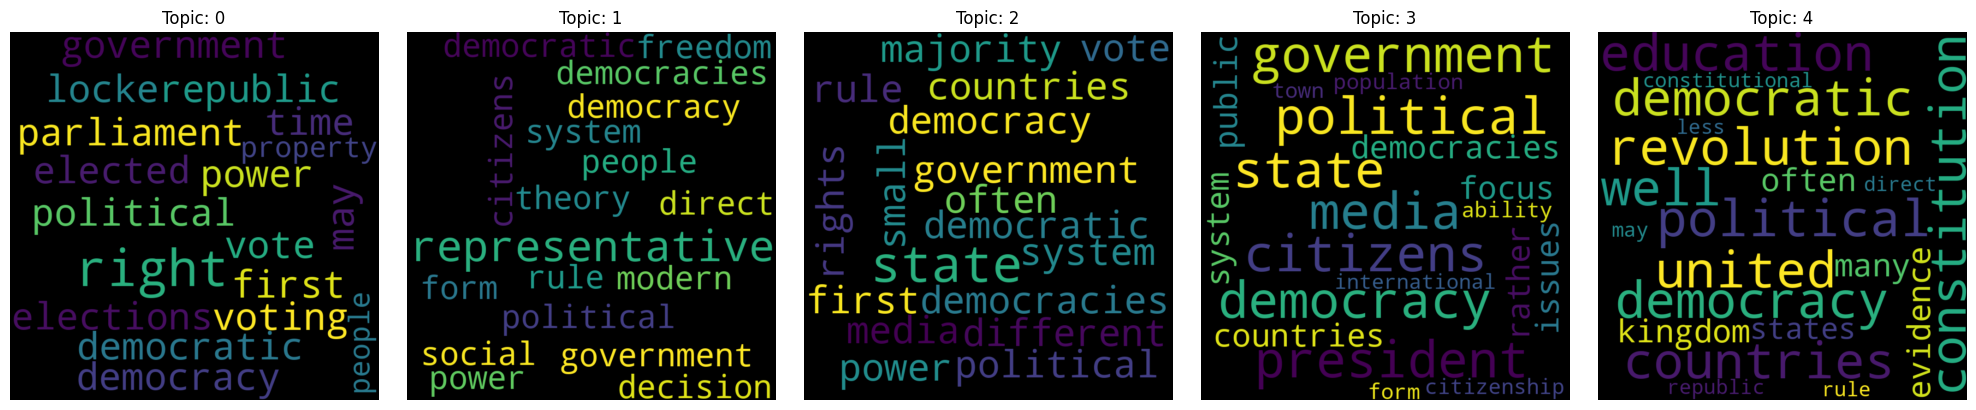

In [ ]:
## code from https://www.analyticsvidhya.com/blog/2023/02/topic-modeling-using-latent-dirichlet-allocation-lda/

fig, axes = plt.subplots(1, num_cols, figsize=(20, 4))

for topic_id, topic in enumerate(lda_model.print_topics(num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(topic_words)
    col_id = topic_id % num_cols
    axes[col_id].imshow(wordcloud, interpolation="bilinear")
    axes[col_id].axis("off")
    axes[col_id].set_title("Topic: {}".format(topic_id))

plt.tight_layout()
plt.show()

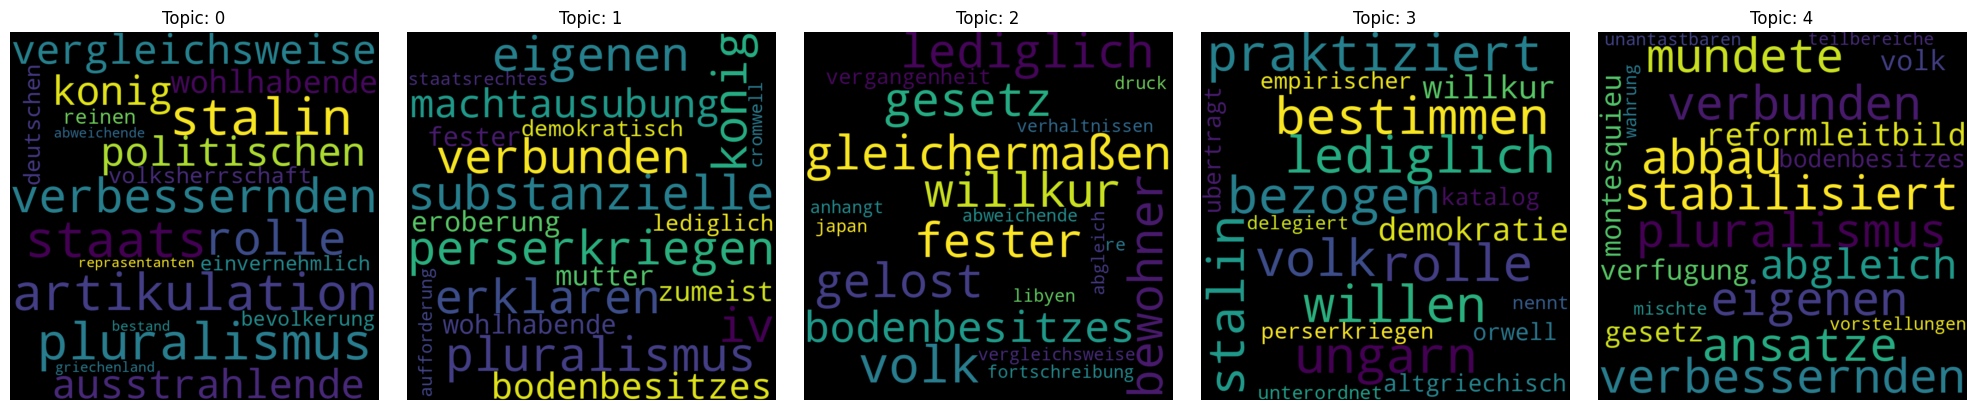

In [ ]:
## code from https://www.analyticsvidhya.com/blog/2023/02/topic-modeling-using-latent-dirichlet-allocation-lda/

fig, axes = plt.subplots(1, num_cols, figsize=(20, 4))

for topic_id, topic in enumerate(lda_model_de.print_topics(num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(topic_words)
    col_id = topic_id % num_cols
    axes[col_id].imshow(wordcloud, interpolation="bilinear")
    axes[col_id].axis("off")
    axes[col_id].set_title("Topic: {}".format(topic_id))

plt.tight_layout()
plt.show()

## Sentiment Analysis:

We now proceed to doing sentiment analysis of the texts. The approach used wants to learn not only the overall polarity of the text but which words contribute to its negativity.

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
### key

openai_fk = open("openai.txt", "r")
key = openai_fk.read()
print("key read")

key read


In [ ]:
sentences_en = get_sentences("https://en.wikipedia.org/wiki/Democracy", "english")

https://en.wikipedia.org/wiki/Democracy


In [ ]:
from openai import OpenAI
client = OpenAI(api_key = key)

resps = []
for sents_en in sentences_en:
  prompt = "Please give me the polarity of the following sentence (please give me the actual numbers and the words that contribute to the negative, neutral, and positive scores). Sentence: '{0}'".format(sents_en)
  response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system", "content": prompt}
    ]
  )
  resps.append(response.choices[0].message.content)

In [ ]:
for u, x in enumerate(['a', 'b', 'c']):
  print(u, x)

0 a
1 b
2 c


In [ ]:
output_en = open("output chatgpt english.txt", "w")
for idx, out in enumerate(resps):
  output_en.write("\nPrompt " + str(idx) + "\n\n" + "Original sentence: " + sentences_en[idx] + "\n\nAnswer:\n\n" + out + "\n")
output_en.close()

In [ ]:
text = "Democratic assemblies are as old as the human species and are found throughout human history,[33] but up until the nineteenth century, major political figures have largely opposed democracy"
scores = sid.polarity_scores(text)

In [ ]:
print("Sentiment scores:", scores)

Sentiment scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [ ]:
negative_words = []
words = text.split()
for word in words:
    if sid.polarity_scores(word)['compound'] < 0:
        negative_words.append(word)

print("Negative words:", negative_words)

Negative words: ['shit']


## Multilingual embeddings:

This section contains the multilingual analysis of similarity between two languages, using model `paraphrase-multilingual-MiniLM-L12-v2`, more on the model can be found here https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2.

First we have to import our model:

In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Obtaining one sample page, the term on *democracy* on Wikipedia, and separating it into sentences. The same procedure is repeated over 5 different languages.

In [ ]:
def get_sentences(sample_page, language):
  page = requests.get(sample_page)
  soup = BeautifulSoup(page.text)
  text_ps = [re.sub(r'\[[0-9]*\]', '', x.getText()) for x in soup.find_all('p')]
  text_ps = [x.lower() for x in text_ps]
  text_ps_en = [re.sub(r'[,\.!?\"]', '', x) for x in text_ps]
  stop_words = stopwords.words(language.lower())
  complete = []
  for sent in text_ps_en:
    text = []
    for word in [x for x in sent.split()]:
      if word not in stop_words:
        text.append(word)
    text = ' '.join(text)
    complete.append(text)
  return complete

In [ ]:
urls = [
    "https://en.wikipedia.org/wiki/Democracy",
    "https://de.wikipedia.org/wiki/Demokratie",
    "https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F",
    "https://ar.wikipedia.org/wiki/%D8%AF%D9%8A%D9%85%D9%82%D8%B1%D8%A7%D8%B7%D9%8A%D8%A9"
    "https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB"
]
langs = ["English", "German", "Russian", "Arabic", "Chinese"]
texts = [get_sentences(urls[i], langs[i]) for i in range(0, len(urls))]
print(texts[0])

['', 'list forms government', "democracy (from ancient greek: δημοκρατία romanized: dēmokratía dēmos 'people' kratos 'rule') system government state power vested people general population state minimalist definition democracy rulers elected competitive elections expansive definitions link democracy guarantees civil liberties human rights addition competitive elections", 'direct democracy people direct authority deliberate decide legislation representative democracy people choose governing officials elections considered part people authority shared among delegated people changed time different rates different countries features democracy oftentimes include freedom assembly association personal property freedom religion speech citizenship consent governed voting rights freedom unwarranted governmental deprivation right life liberty minority rights', 'notion democracy evolved time considerably throughout history one find evidence direct democracy communities make decisions popular assembl

In [ ]:
print(get_sentences("https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB", "Chinese"))

['民主（古希臘語：δημοκρᾰτῐ́ᾱ，羅馬化：dēmokratíā），又称民主制、民主主義，舊譯为德謨克拉西[註 1]，原意指人民的统治，δῆμος为人民，κρᾰτῐ́ᾱ意为统治）:4722，是一種政體，其中人民擁有平等參與公共政策的參與權。當中的「人民」包含哪些人及如何分權，是民主發展和憲法的核心議題。民主的基石包括集會及言論自由、通訊自由、平等、公民權、选举权、生命權。民主是一種普遍公認之理想，提供保護和有效實現人權之環境。其古代本义“人民的统治”，即“主权在民”，是一种国家制度，国家权力由公民直接或间接行使。從其字面上來看，代表著主权在民，即「公民做主」。民主用於國家形式，即成為一種國家制度:4722。拉里·戴蒙德指出，现代民主包括四个关键要素：（1）透过自由和公正的选举产生政府；（2）作为公民积极参与政治和公民生活；（3）保护所有公民的人权；（4）法律和程序平等地适用于所有公民。', '自由民主制是民主制度的原則，當中社會大多數人的意志會以代議形式體現出來，與此同時他們的意願會受到一定限制，以保障少數人的權益不受到侵犯。該些限制大多以保障個人權利為目的，例如言論自由、結社自由。民主是一套处理持份者衝突的制度。處理結果會因持份者的行為而異，但不會存有完全控制結果或將來會發生什麼的單一勢力。民主所產生的結果必然是不確定的。民主使得各方勢力認清自身的利益所在，並把權力從一群人下放至一系列規則上。', '相对極權統治、独裁统治或寡头政治，民主有时被称为“多数的统治”。與「專制」相對立:4722。而公民仍只是全民中限定的一部分，低龄者、妇女、奴隶等非自由人都曾或正被限制参与民主的权利。狭义的民主一词经常被使用于描述国家的政治，民主的原则也适用于其他有着统治行为存在的领域。平常所说的民主作风、民主原则、言論自由等民主权利，都从民主之含义派生而来。广义的民主应该是公民在法律下的地位相同，即在一个完整的民主的社会里公民对社会负有相应的责任与义务，建立起社会的法律法规以及对政权控制的选举权与被选举权等等。民主不僅指政體，首先指國體:4722。民主有通过直接或代议方式执行。在直接民主中，公民作為一個整體組成一個管理機構，並直接就每個問題投票；在代議制民主中，公民從他們中間選出代表，這些代表聚集在一起組成一個理事機構，例如立法機關；憲政民主属于代議制民主，多數人的權力在代議

We now proceed to getting the similarity between sentences, the similarity is taken according to cosine similarity:

\begin{align}
cos(θ) = \frac{⟨a, b⟩}{|a| * |b|}
\end{align}

In [ ]:
langs_tensor = list()
for idx, lang in enumerate(langs[0:2]):
  langs_tensor.append([])
  for idx2, lang2 in enumerate(langs[0:2]):
    langs_tensor[idx].append(0)
    print(idx, idx2)
    embedding1 = model.encode(texts[idx], convert_to_tensor=True)
    embedding2 = model.encode(texts[idx2], convert_to_tensor=True)
    cos_scores = util.cos_sim(embedding1, embedding2)
    print(cos_scores)
    langs_tensor[idx][idx2] = cos_scores
    print(lang, lang2)


0 0
tensor([[1.0000, 0.2108, 0.0832,  ..., 0.0730, 0.0339, 0.0316],
        [0.2108, 1.0000, 0.3798,  ..., 0.1592, 0.1852, 0.3017],
        [0.0832, 0.3798, 1.0000,  ..., 0.4141, 0.2153, 0.4311],
        ...,
        [0.0730, 0.1592, 0.4141,  ..., 1.0000, 0.6060, 0.5737],
        [0.0339, 0.1852, 0.2153,  ..., 0.6060, 1.0000, 0.6880],
        [0.0316, 0.3017, 0.4311,  ..., 0.5737, 0.6880, 1.0000]])
English English
0 1
tensor([[0.1245, 0.0788, 0.0417,  ..., 0.5352, 0.4693, 0.7088],
        [0.4374, 0.3332, 0.3472,  ..., 0.2042, 0.6450, 0.1974],
        [0.7856, 0.5278, 0.6155,  ..., 0.1048, 0.2668, 0.0312],
        ...,
        [0.4389, 0.3822, 0.5155,  ..., 0.1072, 0.2788, 0.0605],
        [0.2539, 0.3620, 0.4468,  ..., 0.0511, 0.3523, 0.0344],
        [0.4743, 0.5250, 0.6485,  ..., 0.1737, 0.4728, 0.0159]])
English German
1 0
tensor([[0.1245, 0.4374, 0.7856,  ..., 0.4389, 0.2539, 0.4743],
        [0.0788, 0.3332, 0.5278,  ..., 0.3822, 0.3620, 0.5250],
        [0.0417, 0.3472, 0.6155, 

Now we are able to perform a few analysis, here we are interested. We are particularly interested in seeing if:

1. Documents are equal sentence by sentence (thus examining the diagonal of matrices)

2. Documents have at least one similar sentence (thus making a histogram of the 5 most similar sentences)

3. There is overall similarity between documents (thus analyzing the mean of tensors)

Analyzing means of diagonals of tensors:

In [ ]:
means = pd.DataFrame()
for lang in range(0, len(langs[0:2])):
  means_lang = []
  for lang2 in range(0, len(langs[0:2])):
    means_lang.append(torch.mean(torch.diagonal(langs_tensor[lang][lang2])).item())
  means[langs[lang]] = means_lang
means.index = langs[0:2]

Text(0.5, 1.0, 'Text similarity by diagonals')

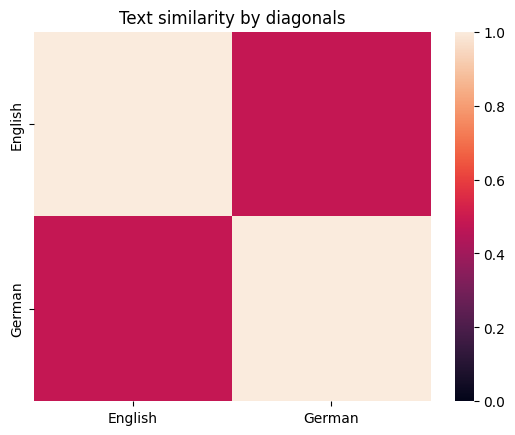

In [ ]:
sns.heatmap(means, vmin=0, vmax=1).set_title('Text similarity by diagonals')

Analyzing overall means:

In [ ]:
means = pd.DataFrame()
for lang in range(0, len(langs[0:2])):
  means_lang = []
  for lang2 in range(0, len(langs[0:2])):
    means_lang.append(torch.mean(langs_tensor[lang][lang2]).item())
  means[langs[lang]] = means_lang
means.index = langs[0:2]

Text(0.5, 1.0, 'Text similarity by means')

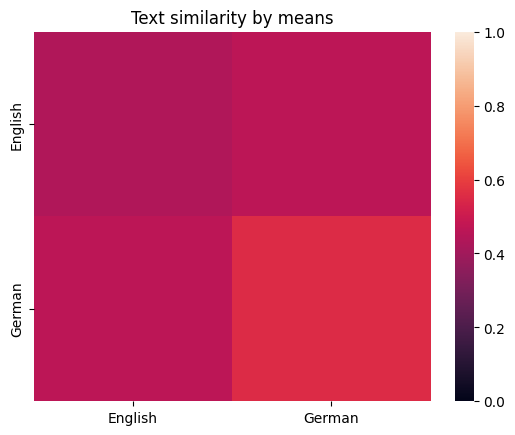

In [ ]:
sns.heatmap(means, vmin=0, vmax=1).set_title('Text similarity by means')

Getting the most similar sentences:

In [ ]:
df = pd.DataFrame()
values = []
keys = []
lang1 = []
lang2 = []
for l1 in range(0, len(langs_tensor)):
  for l2 in range(0, len(langs_tensor[0])):
    mean = torch.mean(torch.transpose(torch.topk(langs_tensor[l1][l2], 5)[0], 0, 1), 1, False)
    for idx, elem in enumerate(mean):
      keys.append(idx)
      values.append(elem.item())
      lang1.append(langs[l1])
      lang2.append(langs[l2])
df['values'] = values
df['keys'] = keys
df['lang1'] = lang1
df['lang2'] = lang2

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


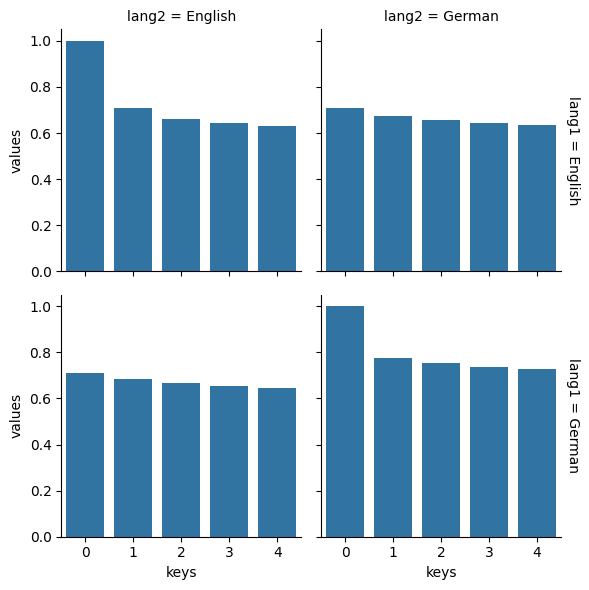

In [ ]:
g = sns.FacetGrid(df, row="lang1", col="lang2", margin_titles=True)
g.map(sns.barplot, "keys", "values")

Now we would like, for comparison, to examine the probability of finding a similar sentence in another language. This is, for example, if I get a random sentence in Russian, what is the probability of finding a similar sentence in English.

The way this will be done is by collecting 385 sentences for comparison. This provides us with a result with a 5% margin of error and 95% level of confidence.

Since the texts have sometimes less than 385 sentences, we will have to collect samples from multiple texts

Collecting sentences in German about Democracy, Violence and European Union

In [ ]:
german = []
german.append(get_sentences("https://de.wikipedia.org/wiki/Demokratie", "German"))
german.append(get_sentences("https://de.wikipedia.org/wiki/Gewalt", "German"))
german.append(get_sentences("https://de.wikipedia.org/wiki/Europ%C3%A4ische_Union", "German"))

Collecting sentences in English:

In [ ]:
english = []
english.append(get_sentences("https://en.wikipedia.org/wiki/Democracy", "English"))
english.append(get_sentences("https://en.wikipedia.org/wiki/Violence", "English"))
english.append(get_sentences("https://en.wikipedia.org/wiki/European_Union", "English"))

Comparing the embeddings:

In [ ]:
cos_sim = []
for idx in range(0, len(english)):
  embedding1 = model.encode(english[idx], convert_to_tensor=True)
  embedding2 = model.encode(german[idx], convert_to_tensor=True)
  cos_scores = util.cos_sim(embedding1, embedding2)
  cos_sim.append(cos_scores)

In [ ]:
total = len(cos_sim[0]) + len(cos_sim[1]) + len(cos_sim[2])

In [ ]:
probs = []
for threshold in range(0, 100, 5):
  num = 0

  for tensor in cos_sim:
    for arr in tensor:
      p = 0
      for elem in arr:
        e = elem.item()
        if e >= threshold/100:
          p = 1
      num += p
  probs.append(num/total)

Text(0.5, 1.0, 'Probability of finding a similar sentence in german by similarity threshold')

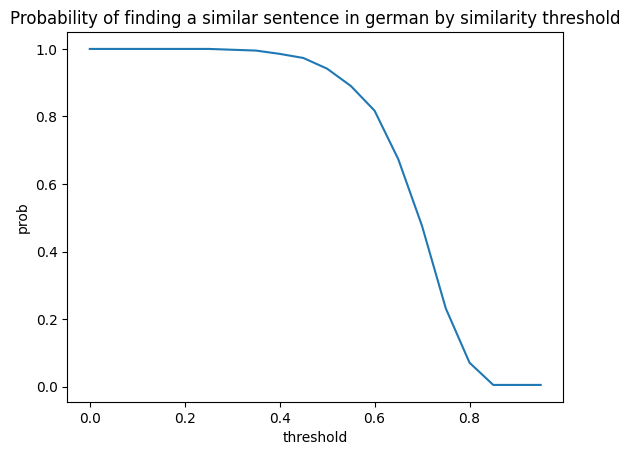

In [ ]:
df = pd.DataFrame(data = {
    "threshold" : [t/100 for t in range(0, 100, 5)],
    "prob" : probs
})

sns.lineplot(df, x = "threshold", y = "prob").set_title("Probability of finding a similar sentence in german by similarity threshold")

### Readability:

In [ ]:
!pip install py-readability-metrics

In [ ]:
from readability import Readability

In [ ]:
r = Readability(' '.join(text_ps_en))

NameError: name 'text_ps_en' is not defined

In [ ]:
def get_readability(urls, labels):
  scores = []
  gl = []
  ages = []
  for url in urls:
    sample_page = url
    page = requests.get(sample_page)
    soup = BeautifulSoup(page.text)
    text_ps = [re.sub(r'\[[0-9]*\]', '', x.getText()) for x in soup.find_all('p')]
    text_ps = [x.lower() for x in text_ps]
    text_ps = [re.sub(r'[,\.!?\"]', '', x) for x in text_ps]
    r = Readability(' '.join(text_ps))
    ari = r.ari()
    scores.append(ari.score)
    gl.append(ari.grade_levels)
    ages.append(ari.ages)
  df = pd.DataFrame(index = labels, data = {
      'ari scores': scores,
      'grade levels': gl,
      'age': ages
  })
  return df

## Use:

In [ ]:
!pip install pyLDAvis
!pip install pandas==1.5.3
import requests
from bs4 import BeautifulSoup
import re
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 29.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Summarization:

Input below the page from which you wish to gather content:

In [ ]:
sample_page = "https://en.wikipedia.org/wiki/Carbon_offsets_and_credits"

Number of words and sentences:

In [ ]:
page = requests.get(sample_page)
soup = BeautifulSoup(page.text)
text_ps = [re.sub(r'\[[0-9]*\]', '', x.getText()) for x in soup.find_all('p')]
text_ps = ' '.join(text_ps)
sentences = sent_tokenize(text_ps)
"words = {0}, sentences = {1}".format(len(text_ps.split()), len(sentences))

'words = 5850, sentences = 390'

In [ ]:
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, corpus, id2word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.103001  0.010125       1        1  20.643656
3     -0.085886  0.057128       2        1  18.466112
9     -0.098837  0.007889       3        1  11.470076
7      0.100061 -0.029044       4        1   9.281597
4     -0.011039  0.119618       5        1   9.091151
0     -0.026428 -0.134802       6        1   9.015618
5     -0.015815 -0.072076       7        1   8.722127
8      0.108587  0.070784       8        1   7.709115
2      0.056088 -0.040939       9        1   4.124254
1      0.076270  0.011317      10        1   1.476294, topic_info=          Term       Freq      Total Category  logprob  loglift
62    projects  51.000000  51.000000  Default  30.0000  30.0000
103     energy  20.000000  20.000000  Default  29.0000  29.0000
126    article  17.000000  17.000000  Default  28.0000  28.0000
131  countries  23.000000  23.000000  Default  27.0000  27.0000
220    project  19.000000  19.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
164        use   0.638079  13.426172  Topic10  -4.4237   1.1691
62    projects   1.246094  51.491261  Topic10  -3.7544   0.4942
12      carbon   0.639730  97.230743  Topic10  -4.4212  -0.8082
3       amount   0.334435   7.237412  Topic10  -5.0698   1.1411
360      types   0.334229  10.864560  Topic10  -5.0704   0.7342

[623 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
554       2  0.270280      able
554       4  0.540559      able
554       8  0.270280      able
1111      5  0.705794    access
754       7  0.704700  accuracy
...     ...       ...       ...
338       3  0.249717     world
339       1  0.323523      zero
339       2  0.161762      zero
339       3  0.161762      zero
339       7  0.323523      zero

[948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 10, 8, 5, 1, 6, 9, 3, 2])

### With multiple languages:

Text similarity with embeddings:

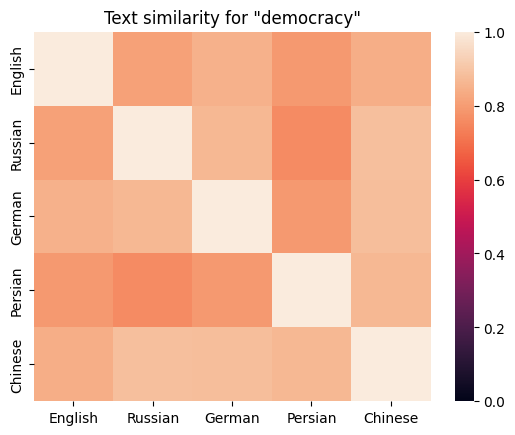

In [ ]:
text_similarity([
    "https://en.wikipedia.org/wiki/Democracy",
    "https://de.wikipedia.org/wiki/Demokratie",
    "https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F",
    "https://fa.wikipedia.org/wiki/%D8%AF%D9%85%D9%88%DA%A9%D8%B1%D8%A7%D8%B3%DB%8C",
    "https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB"
    ], ["English", "Russian", "German", "Persian", "Chinese"], "Text similarity for \"democracy\"", True)

In [ ]:
data = text_similarity([
    "https://en.wikipedia.org/wiki/Democracy",
    "https://de.wikipedia.org/wiki/Demokratie",
    "https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F",
    "https://fa.wikipedia.org/wiki/%D8%AF%D9%85%D9%88%DA%A9%D8%B1%D8%A7%D8%B3%DB%8C",
    "https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB"
    ], ["English", "Russian", "German", "Persian", "Chinese"], "Text similarity for \"democracy\"", False)

In [ ]:
data

,English,Russian,German,Persian,Chinese
English,1.000,0.811,0.849,0.791,0.840
Russian,0.811,1.000,0.866,0.760,0.886
German,0.849,0.866,1.000,0.792,0.882
Persian,0.791,0.760,0.792,1.000,0.865
Chinese,0.840,0.886,0.882,0.865,1.000


Obtaining similarity by means of means of sentences comparison:

Text(0.5, 1.0, 'Text similarity by top similar')

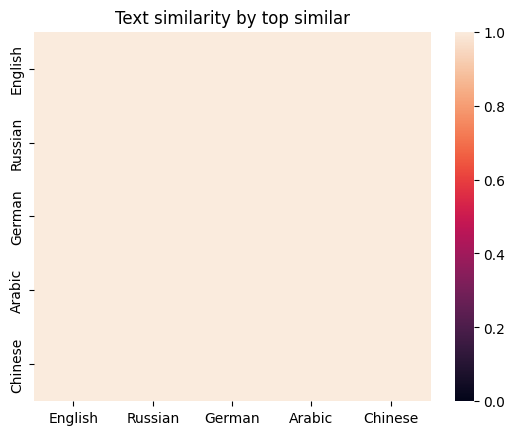

In [ ]:
sns.heatmap(heat, vmin=0, vmax=1).set_title('Text similarity by top similar')

Text(0.5, 1.0, 'Text similarity by diagonals')

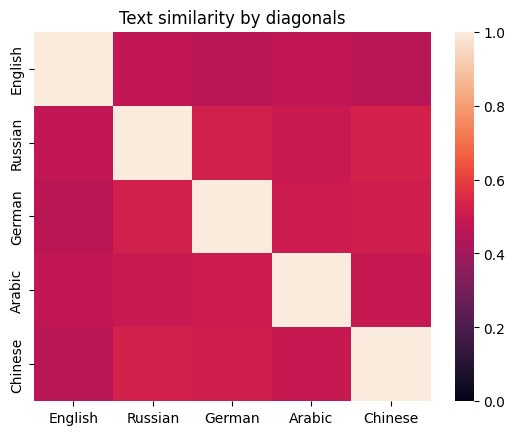

In [ ]:
sns.heatmap(diag, vmin=0, vmax=1).set_title('Text similarity by diagonals')

In [ ]:
sns.heatmap(mean, vmin=0, vmax=1).set_title('Text similarity by mean')

Number of words and sentences:

In [ ]:
bm = get_basic_metrics([
    "https://en.wikipedia.org/wiki/Democracy",
    "https://de.wikipedia.org/wiki/Demokratie",
    "https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F",
    "https://fa.wikipedia.org/wiki/%D8%AF%D9%85%D9%88%DA%A9%D8%B1%D8%A7%D8%B3%DB%8C",
    "https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB"
    ], ["English", "Russian", "German", "Persian", "Chinese"])

https://en.wikipedia.org/wiki/Democracy
https://de.wikipedia.org/wiki/Demokratie
https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F
https://fa.wikipedia.org/wiki/%D8%AF%D9%85%D9%88%DA%A9%D8%B1%D8%A7%D8%B3%DB%8C
https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB
[11539, 16142, 4550, 1262, 113]
[496, 690, 218, 39, 1]


In [ ]:
with open('basic metrics.tex','w') as tf:
    tf.write(bm.to_latex())

Readability metrics:

In [ ]:
read = get_readability([
    "https://en.wikipedia.org/wiki/Democracy",
    "https://de.wikipedia.org/wiki/Demokratie",
    "https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BC%D0%BE%D0%BA%D1%80%D0%B0%D1%82%D0%B8%D1%8F",
    "https://fa.wikipedia.org/wiki/%D8%AF%D9%85%D9%88%DA%A9%D8%B1%D8%A7%D8%B3%DB%8C",
    "https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB"
    ], ["English", "Russian", "German", "Persian", "Chinese"])

In [ ]:
with open('readability.tex','w') as tf:
    tf.write(read.to_latex())

# References

[1] Coppedge, Michael, John Gerring, Carl Henrik Knutsen, Staffan I. Lindberg, Jan Teorell, David Altman, Fabio Angiolillo, Michael Bernhard, Cecilia Borella, Agnes Cornell, M. Steven Fish, Linnea Fox, Lisa Gastaldi, Haakon Gjerlow, Adam Glynn, Ana Good God, Sandra Grahn, Allen Hicken, Katrin Kinzelbach, Joshua Krusell, Kyle L. Marquardt, Kelly McMann, Valeriya Mechkova, Juraj Medzihorsky, Natalia Natsika, Anja Neundorf, Pamela Paxton, Daniel Pemstein, Josefine Pernes, Oskar Rydén, Johannes von Römer, Brigitte Seim, Rachel Sigman, Svend-Erik Skaaning, Jeffrey Staton, Aksel Sundström, Eitan Tzelgov, Yi-ting Wang, Tore Wig, Steven Wilson and Daniel Ziblatt. 2024. ”V-Dem [Country-Year/Country-Date] Dataset v14” Varieties of Democracy (V-Dem) Project. https://doi.org/10.23696/mcwt-fr58.

#